# Day 4 Analysis

For seasons 1999-2021, get a distribution of points scored and check for:
- Outliers
- Is there a relatonship between game type and points scored?

game_type values:
- CON = conference  
- DIV = divisional round  
- REG = regular season  
- SB = superbowl  
- WC = wildcard

## Set Up

In [2]:
import pandas as pd
from os import path
import sqlite3
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import seaborn as sns

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Wrangle the data

Query the schedule table to get info for each game from 1999-2021. Will need to go from wide to tall in order to get the data by team instead of by game.

In [38]:
query = """
WITH data AS (
    SELECT
        game_id,
        season,
        game_type,
        week,
        away_team,
        away_score,
        -- Need to update data to account for 3 teams that switched cities between 1999-2020
        CASE
            WHEN home_team = 'STL' THEN 'LAR'
            WHEN home_team = 'SD' THEN 'LAC'
            WHEN home_team = 'OAK' THEN 'LV'
            ELSE home_team
        END AS home_team,
        home_score,
        roof,
        surface,
        temp,
        wind,
        away_rest,
        home_rest,
        weekday 
    FROM schedules
),
home_games AS (
    SELECT 
        season,
        week, 
        game_type, 
        home_team AS team,
        home_score AS score,
        roof
    FROM data
),
away_games AS (
    SELECT 
        season,
        week, 
        game_type, 
        away_team AS team,
        away_score AS score,
        roof
    FROM data
),
stacked AS (
    SELECT *
    FROM home_games
    UNION
    SELECT *
    FROM away_games
)
SELECT *
FROM stacked
"""

df = pd.read_sql(query, conn)

## Plot

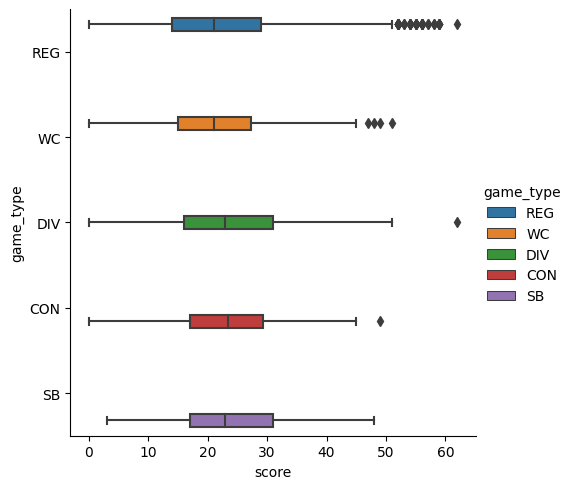

In [42]:
sns.catplot(
    x="score",
    y="game_type",
    data=df,
    kind="box",
    hue="game_type"
)
plt.show()

## Finding Outliers
The outlier that stood out the most was the single divisional game

In [61]:
# Determine IQR to filter the dataset to find the outlier

q1 = df[df['game_type'] == 'DIV']['score'].quantile(0.25)
q3 = df[df['game_type'] == 'DIV']['score'].quantile(0.75)

iqr = 1.5 * (q3 - q1)

df[(df['game_type'] == 'DIV') & ((df['score']) > (q3 + iqr))]

,season,week,game_type,team,score,roof
505,1999,19,DIV,JAX,62.0,outdoors


In [62]:
# Query the schedules table to get more information about the game

pd.read_sql("""
    WITH data AS (
    SELECT
        game_id,
        season,
        game_type,
        week,
        away_team,
        away_score,
        -- Need to update data to account for 3 teams that switched cities between 1999-2020
        CASE
            WHEN home_team = 'STL' THEN 'LAR'
            WHEN home_team = 'SD' THEN 'LAC'
            WHEN home_team = 'OAK' THEN 'LV'
            ELSE home_team
        END AS home_team,
        home_score,
        roof,
        surface,
        temp,
        wind,
        away_rest,
        home_rest,
        weekday 
    FROM schedules
    )
    SELECT *
    FROM data
    WHERE season = 1999 AND game_type = 'DIV' AND (home_team = 'JAX' OR away_team = 'JAX')
""", conn)

,game_id,season,game_type,week,away_team,away_score,home_team,home_score,roof,surface,temp,wind,away_rest,home_rest,weekday
0,1999_19_MIA_JAX,1999,DIV,19,MIA,7.0,JAX,62.0,outdoors,grass,57.0,14.0,6,13,Saturday


Is this score really that rare?

In [60]:
pd.read_sql("""
    WITH data AS (
    SELECT
        game_id,
        season,
        game_type,
        week,
        away_team,
        away_score,
        -- Need to update data to account for 3 teams that switched cities between 1999-2020
        CASE
            WHEN home_team = 'STL' THEN 'LAR'
            WHEN home_team = 'SD' THEN 'LAC'
            WHEN home_team = 'OAK' THEN 'LV'
            ELSE home_team
        END AS home_team,
        home_score,
        roof,
        surface,
        temp,
        wind,
        away_rest,
        home_rest,
        weekday 
    FROM schedules
    )
    SELECT 
    round(((SELECT COUNT(*) FROM data WHERE home_score >= 55 OR away_score >= 55) * 1.0) / COUNT(*) * 100,2) AS pct_of_gte50
    FROM data
    
""", conn)

,pct_of_gte50
0,0.41
